In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import boto3
from sqlalchemy import create_engine
from io import StringIO
from config import aws_id, aws_secret, sql_pwd
import time

## Loading merged dataset

In [2]:
# Loading merged dataset Final_allDatasets_df.csv
path = "Merged_datasets/Final_allDatasets_df.csv"
movies_df = pd.read_csv(path)
movies_df

,Unnamed: 0,budget_ds-movies,company,country,director,genre,gross,rating,score,star,...,vote_count,Ave_runtime,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,0,16000000.0,Thorn EMI Screen Entertainment,UK,Russell Mulcahy,Action,5900000.0,R,7.2,Christopher Lambert,...,624,116.0,18+,7.1,69%,0,0,1,0,0
1,1,25000000.0,Paramount Pictures,USA,Michael Ritchie,Action,79817937.0,PG-13,5.9,Eddie Murphy,...,304,94.0,13+,6.0,26%,0,0,1,0,0
2,2,16000000.0,Act III Communications,USA,Rob Reiner,Adventure,30857814.0,PG,8.1,Cary Elwes,...,1486,98.0,7+,8.1,97%,0,0,0,1,0
3,3,1000000.0,Cinemarque Entertainment BV,UK,Clive Barker,Horror,14564027.0,R,7.0,Andrew Robinson,...,449,94.0,18+,7.0,70%,0,0,1,0,0
4,4,6500000.0,Columbia Pictures Corporation,USA,Luis Valdez,Biography,54215416.0,PG-13,6.8,Lou Diamond Phillips,...,116,108.0,13+,6.9,90%,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,589,80000000.0,Walt Disney Pictures,USA,Craig Gillespie,Action,27550735.0,PG-13,6.8,Chris Pine,...,588,115.5,13+,6.8,64%,0,0,0,1,0
590,590,0.0,20th Century Fox,South Korea,Hong-jin Na,Drama,785405.0,NOT RATED,7.5,Jun Kunimura,...,250,156.0,18+,7.5,99%,0,0,1,0,0
591,591,65000000.0,Walt Disney Pictures,USA,David Lowery,Action,76204454.0,PG,6.7,Bryce Dallas Howard,...,679,102.0,7+,6.7,88%,0,0,0,1,0
592,592,8500000.0,Bron Studios,USA,Nate Parker,Biography,15858754.0,R,6.3,Nate Parker,...,178,120.0,7+,6.4,93%,0,0,1,0,0


## Prepare data for machine learning

In [3]:
# Review columns and decide which columns to use for the model
movies_df.columns.tolist()

['Unnamed: 0',
 'budget_ds-movies',
 'company',
 'country',
 'director',
 'genre',
 'gross',
 'rating',
 'score',
 'star',
 'votes',
 'writer',
 'year',
 'original_language',
 'popularity',
 'revenue',
 'status',
 'title',
 'vote_average',
 'vote_count',
 'Ave_runtime',
 'Age',
 'IMDb',
 'Rotten Tomatoes',
 'Netflix',
 'Hulu',
 'Prime Video',
 'Disney+',
 'Type']

In [4]:
movies_df = movies_df.drop(columns=['Unnamed: 0'])

In [5]:
# Check data type for columns
movies_df.dtypes

budget_ds-movies     float64
company               object
country               object
director              object
genre                 object
gross                float64
rating                object
score                float64
star                  object
votes                  int64
writer                object
year                   int64
original_language     object
popularity           float64
revenue                int64
status                object
title                 object
vote_average         float64
vote_count             int64
Ave_runtime          float64
Age                   object
IMDb                 float64
Rotten Tomatoes       object
Netflix                int64
Hulu                   int64
Prime Video            int64
Disney+                int64
Type                   int64
dtype: object

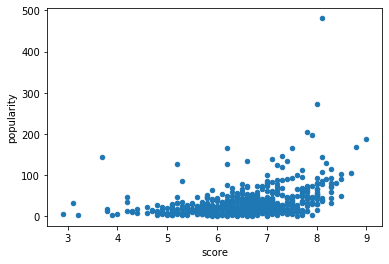

In [6]:
# Find correlation between score and popularity
movies_df.plot(x='score', y='popularity', kind='scatter')

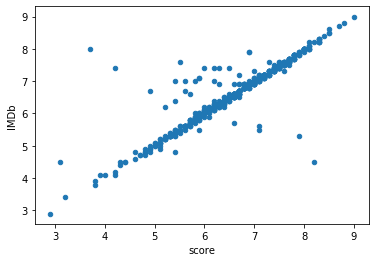

In [7]:
# Find correlation between score and IMDb
movies_df.plot(x='score', y='IMDb', kind='scatter')

In [8]:
# Convert Rotten Tomatoes to string
# Extract the % symbol from the number and convert to string
movies_df['Rotten Tomatoes'] = (movies_df['Rotten Tomatoes'].str.strip('%').astype(int))
movies_df.head()

,budget_ds-movies,company,country,director,genre,gross,rating,score,star,votes,...,vote_count,Ave_runtime,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,16000000.0,Thorn EMI Screen Entertainment,UK,Russell Mulcahy,Action,5900000.0,R,7.2,Christopher Lambert,104860,...,624,116.0,18+,7.1,69,0,0,1,0,0
1,25000000.0,Paramount Pictures,USA,Michael Ritchie,Action,79817937.0,PG-13,5.9,Eddie Murphy,42997,...,304,94.0,13+,6.0,26,0,0,1,0,0
2,16000000.0,Act III Communications,USA,Rob Reiner,Adventure,30857814.0,PG,8.1,Cary Elwes,320953,...,1486,98.0,7+,8.1,97,0,0,0,1,0
3,1000000.0,Cinemarque Entertainment BV,UK,Clive Barker,Horror,14564027.0,R,7.0,Andrew Robinson,83209,...,449,94.0,18+,7.0,70,0,0,1,0,0
4,6500000.0,Columbia Pictures Corporation,USA,Luis Valdez,Biography,54215416.0,PG-13,6.8,Lou Diamond Phillips,22839,...,116,108.0,13+,6.9,90,1,0,0,0,0


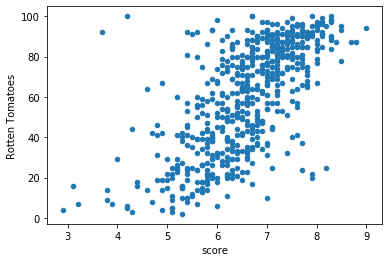

In [9]:
# Find correlation between score and Rotten Tomatoes
movies_df.plot(x='score', y='Rotten Tomatoes', kind='scatter')

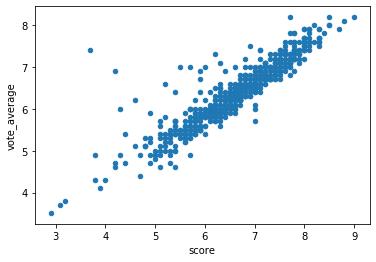

In [10]:
# Find correlation between score and vote_average
movies_df.plot(x='score', y='vote_average', kind='scatter')

In [11]:
# Based on correlations with score, we need to drop vote_average and IMDb columns
movies_df = movies_df.drop(columns=['vote_average','IMDb'])
movies_df

,budget_ds-movies,company,country,director,genre,gross,rating,score,star,votes,...,title,vote_count,Ave_runtime,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,16000000.0,Thorn EMI Screen Entertainment,UK,Russell Mulcahy,Action,5900000.0,R,7.2,Christopher Lambert,104860,...,Highlander,624,116.0,18+,69,0,0,1,0,0
1,25000000.0,Paramount Pictures,USA,Michael Ritchie,Action,79817937.0,PG-13,5.9,Eddie Murphy,42997,...,The Golden Child,304,94.0,13+,26,0,0,1,0,0
2,16000000.0,Act III Communications,USA,Rob Reiner,Adventure,30857814.0,PG,8.1,Cary Elwes,320953,...,The Princess Bride,1486,98.0,7+,97,0,0,0,1,0
3,1000000.0,Cinemarque Entertainment BV,UK,Clive Barker,Horror,14564027.0,R,7.0,Andrew Robinson,83209,...,Hellraiser,449,94.0,18+,70,0,0,1,0,0
4,6500000.0,Columbia Pictures Corporation,USA,Luis Valdez,Biography,54215416.0,PG-13,6.8,Lou Diamond Phillips,22839,...,La Bamba,116,108.0,13+,90,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,80000000.0,Walt Disney Pictures,USA,Craig Gillespie,Action,27550735.0,PG-13,6.8,Chris Pine,47688,...,The Finest Hours,588,115.5,13+,64,0,0,0,1,0
590,0.0,20th Century Fox,South Korea,Hong-jin Na,Drama,785405.0,NOT RATED,7.5,Jun Kunimura,21562,...,The Wailing,250,156.0,18+,99,0,0,1,0,0
591,65000000.0,Walt Disney Pictures,USA,David Lowery,Action,76204454.0,PG,6.7,Bryce Dallas Howard,41083,...,Pete's Dragon,679,102.0,7+,88,0,0,0,1,0
592,8500000.0,Bron Studios,USA,Nate Parker,Biography,15858754.0,R,6.3,Nate Parker,14778,...,The Birth of a Nation,178,120.0,7+,93,0,0,1,0,0


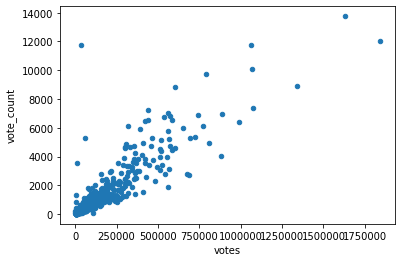

In [12]:
# Find if any correlation between votes and vote_count
movies_df.plot(x='votes', y='vote_count', kind='scatter')

In [13]:
# Divide vote_count by 100 and create a column named Votes_Count, then drop votes and vote_count
movies_df['Votes_Count'] = (movies_df['vote_count']/100)
movies_df = movies_df.drop(columns=['votes','vote_count'])
movies_df.head()

,budget_ds-movies,company,country,director,genre,gross,rating,score,star,writer,...,title,Ave_runtime,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Votes_Count
0,16000000.0,Thorn EMI Screen Entertainment,UK,Russell Mulcahy,Action,5900000.0,R,7.2,Christopher Lambert,Gregory Widen,...,Highlander,116.0,18+,69,0,0,1,0,0,6.24
1,25000000.0,Paramount Pictures,USA,Michael Ritchie,Action,79817937.0,PG-13,5.9,Eddie Murphy,Dennis Feldman,...,The Golden Child,94.0,13+,26,0,0,1,0,0,3.04
2,16000000.0,Act III Communications,USA,Rob Reiner,Adventure,30857814.0,PG,8.1,Cary Elwes,William Goldman,...,The Princess Bride,98.0,7+,97,0,0,0,1,0,14.86
3,1000000.0,Cinemarque Entertainment BV,UK,Clive Barker,Horror,14564027.0,R,7.0,Andrew Robinson,Clive Barker,...,Hellraiser,94.0,18+,70,0,0,1,0,0,4.49
4,6500000.0,Columbia Pictures Corporation,USA,Luis Valdez,Biography,54215416.0,PG-13,6.8,Lou Diamond Phillips,Luis Valdez,...,La Bamba,108.0,13+,90,1,0,0,0,0,1.16


In [14]:
# Find unique values for type column
movies_df.Type.value_counts()

0    594
Name: Type, dtype: int64

In [15]:
# Type column only has "0", drop this column
movies_df = movies_df.drop(columns=['Type'])

In [16]:
# Check which variables needs bucketing
# Company
company_counts = movies_df.company.value_counts()
company_counts.head(60)

Paramount Pictures                        54
Walt Disney Pictures                      52
Warner Bros.                              26
Universal Pictures                        23
Columbia Pictures Corporation             18
Columbia Pictures                         15
Metro-Goldwyn-Mayer (MGM)                 15
DreamWorks                                12
Twentieth Century Fox Film Corporation    12
Pixar Animation Studios                   11
Lionsgate                                 11
New Line Cinema                           10
DreamWorks Animation                       9
Marvel Studios                             6
Paramount Vantage                          6
Dimension Films                            6
Touchstone Pictures                        5
Miramax                                    5
Millennium Films                           5
Summit Entertainment                       5
Walt Disney Animation Studios              5
Screen Gems                                5
Relativity

In [17]:
# Country
country_counts = movies_df.country.value_counts()
country_counts.head(30)

USA            494
UK              54
Germany          9
France           7
Canada           7
Spain            6
China            3
South Korea      3
Hong Kong        2
Australia        2
Ireland          1
Italy            1
India            1
Sweden           1
Netherlands      1
Japan            1
Mexico           1
Name: country, dtype: int64

In [18]:
# Director
director_counts = movies_df.director.value_counts()
director_counts.head(60)

Steven Spielberg        6
Gore Verbinski          5
Quentin Tarantino       5
John Lasseter           5
Robert Zemeckis         4
Jay Roach               4
Michael Bay             4
Tim Burton              4
Kevin Smith             4
Ethan Coen              4
Joel Schumacher         3
Ivan Reitman            3
Lasse Hallstrm          3
Lana Wachowski          3
Noah Baumbach           3
Garry Marshall          3
Ron Clements            3
Christopher Nolan       3
Antoine Fuqua           3
Shekhar Kapur           3
David Fincher           3
Paul Thomas Anderson    3
Joss Whedon             3
Pete Docter             3
Paul W.S. Anderson      3
Sam Mendes              2
Phillip Noyce           2
George Lucas            2
Andrew Niccol           2
Andrew Stanton          2
Jason Reitman           2
Gavin O'Connor          2
Tarsem Singh            2
Eric Darnell            2
Kimberly Peirce         2
Rob Minkoff             2
Roger Allers            2
Mark Waters             2
Andy Fickman

In [19]:
# Genre
genre_counts = movies_df.genre.value_counts()
genre_counts

Action       141
Comedy       133
Drama         89
Animation     71
Biography     43
Crime         41
Adventure     40
Horror        31
Mystery        1
Fantasy        1
Thriller       1
Western        1
Sci-Fi         1
Name: genre, dtype: int64

In [20]:
# Rating
rating_counts = movies_df.rating.value_counts()
rating_counts

R            247
PG-13        185
PG           118
G             42
NOT RATED      2
Name: rating, dtype: int64

In [21]:
# Star
star_counts = movies_df.star.value_counts()
star_counts

Johnny Depp          11
Christian Bale        7
Brad Pitt             7
Will Smith            6
Nicolas Cage          6
                     ..
Dale Midkiff          1
Jack Nicholson        1
Chlo Grace Moretz     1
Kenneth Branagh       1
Kevin Costner         1
Name: star, Length: 399, dtype: int64

In [22]:
# Age
age_counts = movies_df.Age.value_counts()
age_counts

18+    251
13+    175
7+     119
all     49
Name: Age, dtype: int64

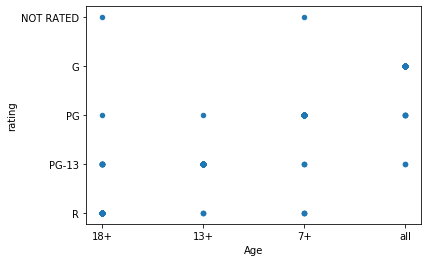

In [23]:
# Find correlation between age and rating
movies_df.plot(x='Age', y='rating', kind='scatter')

In [24]:
# writer
writer_counts = movies_df.writer.value_counts()
writer_counts

John Lasseter        6
Quentin Tarantino    5
Joss Whedon          4
John Logan           4
Ted Elliott          4
                    ..
Melissa Rosenberg    1
Leo Benvenuti        1
J.H. Wyman           1
David Guion          1
Michael Kinirons     1
Name: writer, Length: 499, dtype: int64

In [25]:
# original_language
original_language_counts = movies_df.original_language.value_counts()
original_language_counts

en    577
es      3
ko      3
zh      2
cn      2
hi      1
nl      1
it      1
fr      1
de      1
pt      1
ja      1
Name: original_language, dtype: int64

In [26]:
# Year
year_counts = movies_df.year.value_counts()
year_counts

2010    52
2011    40
2012    36
2009    34
2008    34
2003    32
2013    31
2002    31
2005    28
2006    26
2014    25
2000    24
2015    23
1998    21
2004    21
1997    19
2001    17
1999    15
2007    13
1995    11
2016    11
1996     7
1987     7
1991     6
1993     5
1992     5
1989     5
1988     5
1994     4
1990     4
1986     2
Name: year, dtype: int64

In [27]:
# Apply bucketing to company column
# Determine which values to replace
replace_companies = list(company_counts[company_counts < 5].index)

# Replace in DataFrame
for company in replace_companies:
    movies_df.company = movies_df.company.replace(company,"Other")


# Check to make sure binning was successful
movies_df.company.value_counts()

Other                                     278
Paramount Pictures                         54
Walt Disney Pictures                       52
Warner Bros.                               26
Universal Pictures                         23
Columbia Pictures Corporation              18
Columbia Pictures                          15
Metro-Goldwyn-Mayer (MGM)                  15
DreamWorks                                 12
Twentieth Century Fox Film Corporation     12
Pixar Animation Studios                    11
Lionsgate                                  11
New Line Cinema                            10
DreamWorks Animation                        9
Paramount Vantage                           6
Marvel Studios                              6
Dimension Films                             6
Screen Gems                                 5
Millennium Films                            5
Walt Disney Animation Studios               5
Miramax                                     5
Summit Entertainment              

In [28]:
# Drop columns: star, director, writer, status, title
movies_df = movies_df.drop(columns=['star', 'director', 'writer', 'status', 'year'])
movies_df

,budget_ds-movies,company,country,genre,gross,rating,score,original_language,popularity,revenue,title,Ave_runtime,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Votes_Count
0,16000000.0,Other,UK,Action,5900000.0,R,7.2,en,29.253833,5900000,Highlander,116.0,18+,69,0,0,1,0,6.24
1,25000000.0,Paramount Pictures,USA,Action,79817937.0,PG-13,5.9,en,15.262130,79817939,The Golden Child,94.0,13+,26,0,0,1,0,3.04
2,16000000.0,Other,USA,Adventure,30857814.0,PG,8.1,en,44.533612,30857814,The Princess Bride,98.0,7+,97,0,0,0,1,14.86
3,1000000.0,Other,UK,Horror,14564027.0,R,7.0,en,22.583834,14564027,Hellraiser,94.0,18+,70,0,0,1,0,4.49
4,6500000.0,Columbia Pictures Corporation,USA,Biography,54215416.0,PG-13,6.8,en,6.847099,54215416,La Bamba,108.0,13+,90,1,0,0,0,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,80000000.0,Walt Disney Pictures,USA,Action,27550735.0,PG-13,6.8,en,28.223664,52099090,The Finest Hours,115.5,13+,64,0,0,0,1,5.88
590,0.0,Other,South Korea,Drama,785405.0,NOT RATED,7.5,ko,9.050290,0,The Wailing,156.0,18+,99,0,0,1,0,2.50
591,65000000.0,Walt Disney Pictures,USA,Action,76204454.0,PG,6.7,en,31.974359,143695338,Pete's Dragon,102.0,7+,88,0,0,0,1,6.79
592,8500000.0,Other,USA,Biography,15858754.0,R,6.3,en,9.452808,15861566,The Birth of a Nation,120.0,7+,93,0,0,1,0,1.78


In [29]:
# Create copy of the movies_df
movies_df_copy = movies_df.copy()
movies_df_copy

,budget_ds-movies,company,country,genre,gross,rating,score,original_language,popularity,revenue,title,Ave_runtime,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Votes_Count
0,16000000.0,Other,UK,Action,5900000.0,R,7.2,en,29.253833,5900000,Highlander,116.0,18+,69,0,0,1,0,6.24
1,25000000.0,Paramount Pictures,USA,Action,79817937.0,PG-13,5.9,en,15.262130,79817939,The Golden Child,94.0,13+,26,0,0,1,0,3.04
2,16000000.0,Other,USA,Adventure,30857814.0,PG,8.1,en,44.533612,30857814,The Princess Bride,98.0,7+,97,0,0,0,1,14.86
3,1000000.0,Other,UK,Horror,14564027.0,R,7.0,en,22.583834,14564027,Hellraiser,94.0,18+,70,0,0,1,0,4.49
4,6500000.0,Columbia Pictures Corporation,USA,Biography,54215416.0,PG-13,6.8,en,6.847099,54215416,La Bamba,108.0,13+,90,1,0,0,0,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,80000000.0,Walt Disney Pictures,USA,Action,27550735.0,PG-13,6.8,en,28.223664,52099090,The Finest Hours,115.5,13+,64,0,0,0,1,5.88
590,0.0,Other,South Korea,Drama,785405.0,NOT RATED,7.5,ko,9.050290,0,The Wailing,156.0,18+,99,0,0,1,0,2.50
591,65000000.0,Walt Disney Pictures,USA,Action,76204454.0,PG,6.7,en,31.974359,143695338,Pete's Dragon,102.0,7+,88,0,0,0,1,6.79
592,8500000.0,Other,USA,Biography,15858754.0,R,6.3,en,9.452808,15861566,The Birth of a Nation,120.0,7+,93,0,0,1,0,1.78


In [30]:
# Define function for OneHot Encoder

def encoding():
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(sparse=False)

    # Fit the encoder and produce encoded DataFrame
    encode_df = pd.DataFrame(enc.fit_transform(transform))

    # Rename encoded columns
    encode_df.columns = enc.get_feature_names([column_name])
    encode_df.head()
    
    # Merge the two DataFrames together and drop the company column
    movies_merged_df = movies_df_copy.merge(encode_df,left_index=True,right_index=True).drop(column_name,1)
    return movies_merged_df

In [31]:
# # Pending to find a for loop for the encoding
# columns_to_encode = ['company', 'country', 'genre', 'rating', 'Age', 'original_language', 'year']

# for column in columns_to_encode:
#     transform = movies_df_copy.column.values.reshape(-1,1)
#     column_name = "column"
#     # Call the function to apply encoding to the variable
#     movies_df_copy = encoding()

In [32]:
# Encoding company
transform = movies_df_copy.company.values.reshape(-1,1)
column_name = "company"
# Call the function to apply encoding to the variable
movies_df_copy = encoding()

In [33]:
# Encoding country
transform = movies_df_copy.country.values.reshape(-1,1)
column_name = "country"
# Call the function to apply encoding to the variable
movies_df_copy = encoding()

In [34]:
# # Encoding genre
# transform = movies_df_copy.genre.values.reshape(-1,1)
# column_name = "genre"
# # Call the function to apply encoding to the variable
# movies_df_copy = encoding()

In [35]:
# Encoding rating
transform = movies_df_copy.rating.values.reshape(-1,1)
column_name = "rating"
# Call the function to apply encoding to the variable
movies_df_copy = encoding()

In [36]:
# Encoding Age
transform = movies_df_copy.Age.values.reshape(-1,1)
column_name = "Age"
# Call the function to apply encoding to the variable
movies_df_copy = encoding()

In [37]:
# Encoding original_language
transform = movies_df_copy.original_language.values.reshape(-1,1)
column_name = "original_language"
# Call the function to apply encoding to the variable
movies_df_copy = encoding()

In [38]:
# # Encoding year
# transform = movies_df_copy.year.values.reshape(-1,1)
# column_name = "year"
# # Call the function to apply encoding to the variable
# movies_df_copy = encoding()

In [39]:
movies_df_copy.columns.tolist()
movies_df_copy
movies_df_copy.dtypes

budget_ds-movies        float64
genre                    object
gross                   float64
score                   float64
popularity              float64
                         ...   
original_language_ja    float64
original_language_ko    float64
original_language_nl    float64
original_language_pt    float64
original_language_zh    float64
Length: 75, dtype: object

In [40]:
# Export final datasets in csv
movies_df_copy.to_csv('Final_Movies_dataset.csv', index = False)